In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

Define some auxiliar functions to make the processing easier.

In [2]:
# SI conversion to work always in SI units.
def SI_conversion(df, current_units):
    if current_units['DEPT']:
        df['DEPT'] = df['DEPT']*0.3048
    if current_units['RHOB']:
        df['RHOB'] = df['RHOB']*(1000000/1000)
    if current_units['VP']:
        df['VP'] = df['VP']/3.28084
    if current_units['DT']:
        df['DT'] = df['DT']/(0.3048*(1e6))
        
    return df

In [3]:
# Simple Z calculation from rho and Vp
def calc_Z(df):
    df['Z'] = df['RHOB']*df['VP']
    return df

In [4]:
# Simple r (reflectivity profile) calculation from Z.
def calc_r(df):
    temp = []
    for i in range(1, len(df['Z'])):
        num = df['Z'][i]-df['Z'][i-1]
        den = df['Z'][i]+df['Z'][i-1]
        val = num/den
        temp.append(val)
        if i == len(df['Z'])-1:
            temp.append(temp[-1])
            
    df['r'] = temp
    
    return df

In [5]:
# Add noise to the reflectivity profile
def calc_r_prime(df, noise_weight):
    
    max_amp = abs(df['r']).max()*noise_weight
    noise = np.random.uniform(-max_amp,max_amp,len(df['r']))
    df['r_prime'] = df['r'] + noise
    
    return df

In [6]:
# Recursive inversion methods available to perform seismic inversion
def seis_inv(df, method):
    
    temp = []
    z0 = df['Z'].iloc[0]
    
    if method == 'r any':
        cociente = 1
        # calculate the Acoustic Impedance (Z)
        for i in range(len(df['r_prime'])-1):
            cociente *= (1+df['r_prime'][i])/(1-df['r_prime'][i])
            temp.append(cociente)
        temp.append(temp[-1])
        temp = np.array(temp)*z0
        
    if method == 'r < 0.3':
        # calculate Z
        for i in range(len(df['r_prime'])-1):
            z_temp = z0*np.exp(2*np.sum(df['r_prime'][:i+1]))
            temp.append(z_temp)
        temp.append(temp[-1])
    
    if method == 'r < 0.1':
        # calculate Z
        for i in range(len(df['r_prime'])-1):
            z_temp = (2*z0)*np.sum(df['r_prime'][:i+1])
            temp.append(z_temp)
        temp.append(temp[-1])

    df[f'Z_{method}'] = temp
    
    return df

In [7]:
# Parameters of the Gardner relation in SI units
def give_params():
    
    alpha = 310
    beta = 0.25
        
    return alpha, beta

In [8]:
# Calculate Vp by using Gradner relation
def calc_vp(df, method):

    alpha, beta = give_params() # parameters of the Gardner relation
    vp = (df[f'Z_{method}']/alpha)**(1/(beta+1))
    df[f'VP_{method}'] = vp
    
    return df

In [9]:
# Calculate rho by using Gardner relation
def calc_rho(df, method):
    
    alpha, beta = give_params()   
    rho = alpha*df[f'VP_{method}']**beta
    df[f'RHOB_{method}'] = rho
    
    return df

In [10]:
# Convolution with a generic wavelet to generate a pseudo seismogram of the filed records
def wavelet_conv(df, r):
    
    # calculate convolved signal: wavelet + reflectivity profile
    points = 100
    a = 5
    vec2 = signal.ricker(points, a)
    df[f'waveform_{r}'] = np.convolve(df[r], vec2, 'same')

    return df

In [11]:
# Calculate sonic from Vp
def calc_sonic(df, method):
    
    # calculate the sonic
    if method:
        df[f'DT_{method}'] = 1/df[f'VP_{method}']
    else:
        df['DT'] = 1/df['VP']
    return df

In [12]:
# Plot results (stratigraphic column)
def plot_results(df, method, r):
    
    fig, ax = plt.subplots(1,7, figsize=(10,7), sharey=True, dpi=500)
    lw=.3
    
    i = 0
    if method:
        key = f'DT_{method}'
    else:
        key = 'DT'
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$DT$ $\left(\frac{s}{m}\right)$')
    ax[i].set_ylabel(r'Depth ($m$)')
    ax[i].grid(alpha=.5)
    ax[i].invert_yaxis()
    ax[i].set_axisbelow(True)
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(-4,-4))
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 1
    if method:
        key = f'VP_{method}'
    else:
        key = 'VP'
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$VP$ $\left(\frac{m}{s}\right)$')
    ax[i].grid(alpha=.5)
    ax[i].invert_yaxis()
    ax[i].set_axisbelow(True)
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 2
    if method:
        key = f'RHOB_{method}'
    else:
        key='RHOB'
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True)
    ax[i].ticklabel_format(style='sci', axis='x')
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(3,3))
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 3
    if method:
        key = f'Z_{method}'
    else:
        key='Z'
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$Z$ $\left(\frac{kg}{s \cdot m^2}\right)$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True) 
    ax[i].ticklabel_format(style='sci', axis='x', scilimits=(6,6))
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 4
    key = r
    ax[i].plot(df[key], df['DEPT'], linewidth=lw)
    ax[i].set_title(r'$r$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True)
    ax[i].ticklabel_format(style='sci', axis='x')
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 5
    key = f'waveform_{r}'
    ax[i].plot(df[key], df['DEPT'], linewidth=.1, color='k')
    ax[i].set_title(r'$A$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True)
    ax[i].fill_betweenx(df['DEPT'], x1=df[f'waveform_{r}'], x2=0, where=df[f'waveform_{r}']<=0, color='blue', linewidth=0)
    ax[i].fill_betweenx(df['DEPT'], x1=df[f'waveform_{r}'], x2=0, where=df[f'waveform_{r}']>0, color='red', linewidth=0)
    ax[i].ticklabel_format(style='sci', axis='x')
    ax[i].tick_params(axis='x', labelsize=6)
    
    i = 6
    key = 'TR'
    lithology_data = df['TR']
    unique_labels = np.unique(df['TR'])
    colors = {-9999:'saddlebrown', 1:'sandybrown', 2:'darkgoldenrod', 3:'brown', 4:'dimgray', 5:'yellow'}
    # Plot lithology data
    for j, lithology in enumerate(unique_labels):
        mask = (lithology_data==lithology)
        ax[i].fill_betweenx(df['DEPT'], x1=0, x2=1, where=mask, label=f'{dict_names[unique_labels[j]]}', color=colors[lithology])
    ax[i].set_title(r'$TR$')
    ax[i].grid(alpha=.5)
    ax[i].set_axisbelow(True)
    ax[i].legend(loc='upper right', fontsize=4)
    ax[i].tick_params(axis='x', labelsize=6)
    plt.suptitle(f'Method {method}')

In [13]:
# Remove outlier values that could mess up the inversion.
# By default this set up to delete all values which are 3 standard deviation or more far from the mean.
def remove_outliers(df, threshold=3):
    z_scores = stats.zscore(df)
    abs_z_scores = abs(z_scores)
    filtered_entries = (abs_z_scores < threshold).all(axis=1)  # Adjust the threshold as needed (e.g., 3 standard deviations)
    df_filtered = df[filtered_entries]
    df_filtered.reset_index(drop=True, inplace=True)
    return df_filtered

In [14]:
# Calculate L1 norm (error)
def L1_error(y_true, y_pred):
    n = len(y_true)
    # Calculate the absolute percentage error for each data point
    abs_percentage_error = np.abs((y_pred - y_true) / y_true)
    
    # Calculate the mean absolute percentage error as a percentage of n
    L1 = (np.sum(abs_percentage_error) / n) * 100
    print(f"L1 error: {L1:.2f}%")

# Calculate L2 norm (error)
def L2_error(y_true, y_pred):
    n = len(y_true)
    # Calculate the squared percentage error for each data point
    squared_percentage_error = ((y_true - y_pred) / y_true) ** 2
    
    # Calculate the mean squared percentage error and take the square root as a percentage of n
    L2 = (np.sqrt(np.sum(squared_percentage_error)) / n) * 100
    print(f"L2 error: {L2:.2f}%")

In [15]:
# Calculate Gardner relation and plot it for each type of rock
def calc_Gardner_relation(df):
    
    def gardner_function(x, a, b):
        return a * x**b
    
    for tr in np.unique(df['TR']):
        
        mask = (df['TR'] == tr)
        df_filtered = df[mask]
        df_filtered.reset_index(drop=True, inplace=True)
        df_filtered.sort_values(by='VP', ignore_index=True, inplace=True)
        # fit the data
        popt, _ = curve_fit(gardner_function, df_filtered['VP'], df_filtered['RHOB'])
        # plot fit
        plt.scatter(df_filtered['VP'], df_filtered['RHOB'], s=1)
        R2 = r2_score(df_filtered['RHOB'], gardner_function(df_filtered['VP'], *popt)) # R2 correlation coefficient
        print(f'a: {popt[0]}         b: {popt[1]}')
        plt.plot(df_filtered['VP'], gardner_function(df_filtered['VP'], *popt), 'r', label=f'R2: {np.round(R2, 3)}')
        
        plt.xlabel(r'$V_p$ $\left(\frac{m}{s}\right)$')
        plt.ylabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
        plt.title(f'Gardner relation for TR: {dict_names[tr]}')
        # Get the x-axis and y-axis limits
        x_limits = plt.xlim()
        y_limits = plt.ylim()
        x_offset, y_offset = x_limits[-1]*.1, y_limits[0]*.025
        #plt.text(x_limits[-1]-x_offset,y_limits[0]+y_offset,f'a = {int(popt[0])}')
        #plt.text(x_limits[-1]-x_offset,y_limits[0]+y_limits[0]*.01+y_offset,f'b = {np.round(popt[1],4)}')
        plt.legend()
        plt.show()

In [16]:
# Calculate rho-Z relation and plot it for each type of rock
def calc_NoGardner_relation(df):
    
    def Nogardner_function(x, a, b):
        return a * x + b
    
    for tr in np.unique(df['TR']):
        
        mask = (df['TR'] == tr)
        df_filtered = df[mask]
        df_filtered.reset_index(drop=True, inplace=True)
        df_filtered.sort_values(by='Z', ignore_index=True, inplace=True)
        # fit the data
        popt, _ = curve_fit(Nogardner_function, df_filtered['Z'], df_filtered['RHOB'])
        # plot fit
        plt.scatter(df_filtered['Z'], df_filtered['RHOB'], s=1)
        R2 = r2_score(df_filtered['RHOB'], Nogardner_function(df_filtered['Z'], *popt)) # R2 correlation coefficient
        print(f'a: {popt[0]}         b: {popt[1]}')
        plt.plot(df_filtered['Z'], Nogardner_function(df_filtered['Z'], *popt), 'r', label=f'R2: {R2}')
        
        plt.xlabel(r'$Z$ $\left(\frac{kg}{m^2s}\right)$')
        plt.ylabel(r'$\rho$ $\left(\frac{kg}{m^3}\right)$')
        plt.title(f'No Gardner relation for TR: {dict_names[tr]}')
        # Get the x-axis and y-axis limits
        x_limits = plt.xlim()
        y_limits = plt.ylim()
        x_offset, y_offset = x_limits[-1]*.1, y_limits[0]*.025
        plt.legend()
        plt.show()

#### Load the data

Fields should be named as follows: DEPT (Depth), DT (Sonic), RHOB (Density).

In [17]:
dict_names = {1: 'Arenas buenas', 2: 'Arenas buenas sucias', 3: 'Arenas regulares sucias', 4: 'Arenas malas', 5:'Arcillas', -9999: 'Litología desconocida'}

In [18]:
path_data = "D:\\Users\\serfe\\Desktop\\Maestria geofísica\\1- Semestre 202302\\Inversión sísmica\\0 - Tasks\\Task 2\\Ejercicio Sismica de Reflexion II.csv"
df = pd.read_csv(path_data, sep=';')
# convert units to SI
current_units = {'DEPT':True, 'RHOB':True, 'VP':True, 'DT':False, }
df = SI_conversion(df, current_units)
print(f'Length of original data: {len(df)}')

Length of original data: 1928


In [19]:
# Remove outliers from all columns
df = remove_outliers(df[['DEPT', 'RHOB', 'TR', 'VP']], threshold=3)
print(f'Length of filtered data (without outliers): {len(df)}')

Length of filtered data (without outliers): 1899


#### Calculate fields

In [20]:
### calculate Z and r
df = calc_Z(df)
df = calc_r(df)
df = calc_r_prime(df, 1/100)
# calculate the waveform
method = 'r'
df = wavelet_conv(df, method)
method = 'r_prime'
df = wavelet_conv(df, method)
# calculate DT
df = calc_sonic(df, None)

In [21]:
# method 1
method = 'r any'
df = seis_inv(df, method)
df = calc_vp(df, method)
df = calc_rho(df, method)
df = calc_sonic(df, method)
# method 2
method = 'r < 0.3'
df = seis_inv(df, method)
df = calc_vp(df, method)
df = calc_rho(df, method)
df = calc_sonic(df, method)
# method 3
method = 'r < 0.1'
df = seis_inv(df, method)
df = calc_vp(df, method)
df = calc_rho(df, method)
df = calc_sonic(df, method)

In [22]:
df

DEPT     RHOB  TR           VP             Z         r   r_prime  \
0     1063.4472  2437.95   5  3040.612770  7.412862e+06 -0.020763 -0.019618   
1     1063.7520  2430.98   5  2925.281026  7.111300e+06 -0.011869 -0.009901   
2     1064.0568  2380.59   5  2917.120006  6.944467e+06 -0.010836 -0.010051   
3     1064.3616  2362.44   4  2876.508760  6.795579e+06 -0.022184 -0.023294   
4     1064.6664  2316.35   3  2806.402933  6.500611e+06 -0.004246 -0.005952   
...         ...      ...  ..          ...           ...       ...       ...   
1894  1649.5776  2395.45   3  3271.378671  7.836424e+06  0.014129  0.015726   
1895  1649.8824  2399.41   4  3359.593884  8.061043e+06  0.009245  0.009979   
1896  1650.1872  2404.28   4  3415.357043  8.211475e+06 -0.000863 -0.001308   
1897  1650.4920  2384.71   3  3437.445898  8.197312e+06  0.001770  0.002475   
1898  1650.7968  2413.00   5  3409.190939  8.226378e+06  0.001770  0.001977   

      waveform_r  waveform_r_prime        DT  ...   RHOB_r any  DT_r any  \
0      -0.015018         -0.014454  0.000329  ...  2310.351634  0.000324   
1      -0.023803         -0.023228  0.000342  ...  2301.219840  0.000329   
2      -0.031947         -0.031425  0.000343  ...  2291.986111  0.000335   
3      -0.038465         -0.038029  0.000348  ...  2270.725885  0.000347   
4      -0.042379         -0.042027  0.000356  ...  2265.325765  0.000351   
...          ...               ...       ...  ...          ...       ...   
1894    0.012236          0.014199  0.000306  ...  2375.616807  0.000290   
1895    0.011584          0.013314  0.000298  ...  2385.118674  0.000285   
1896    0.010682          0.012087  0.000293  ...  2383.870891  0.000286   
1897    0.009181          0.010208  0.000291  ...  2386.232388  0.000285   
1898    0.006975          0.007614  0.000293  ...  2386.232388  0.000285   

         Z_r < 0.3   VP_r < 0.3  RHOB_r < 0.3  DT_r < 0.3     Z_r < 0.1  \
0     7.127641e+06  3085.086257   2310.353961    0.000324 -2.908527e+05   
1     6.987893e+06  3036.600349   2301.222455    0.000329 -4.376370e+05   
2     6.848822e+06  2988.156642   2291.989026    0.000335 -5.866530e+05   
3     6.537071e+06  2878.837860   2270.732601    0.000347 -9.319997e+05   
4     6.459710e+06  2851.550513   2265.332528    0.000351 -1.020248e+06   
...            ...          ...           ...         ...           ...   
1894  8.240738e+06  3464.842888   2378.387318    0.000289  7.848246e+05   
1895  8.406861e+06  3520.608476   2387.899950    0.000284  9.327719e+05   
1896  8.384893e+06  3513.246987   2386.650712    0.000285  9.133765e+05   
1897  8.426507e+06  3527.188752   2389.014959    0.000284  9.500747e+05   
1898  8.426507e+06  3527.188752   2389.014959    0.000284  9.500747e+05   

      VP_r < 0.1  RHOB_r < 0.1  DT_r < 0.1  
0            NaN           NaN         NaN  
1            NaN           NaN         NaN  
2            NaN           NaN         NaN  
3            NaN           NaN         NaN  
4            NaN           NaN         NaN  
...          ...           ...         ...  
1894  528.115288   1486.085781    0.001894  
1895  606.360644   1538.312061    0.001649  
1896  596.252915   1531.860870    0.001677  
1897  615.342412   1543.977283    0.001625  
1898  615.342412   1543.977283    0.001625  

[1899 rows x 22 columns]

#### Plot results

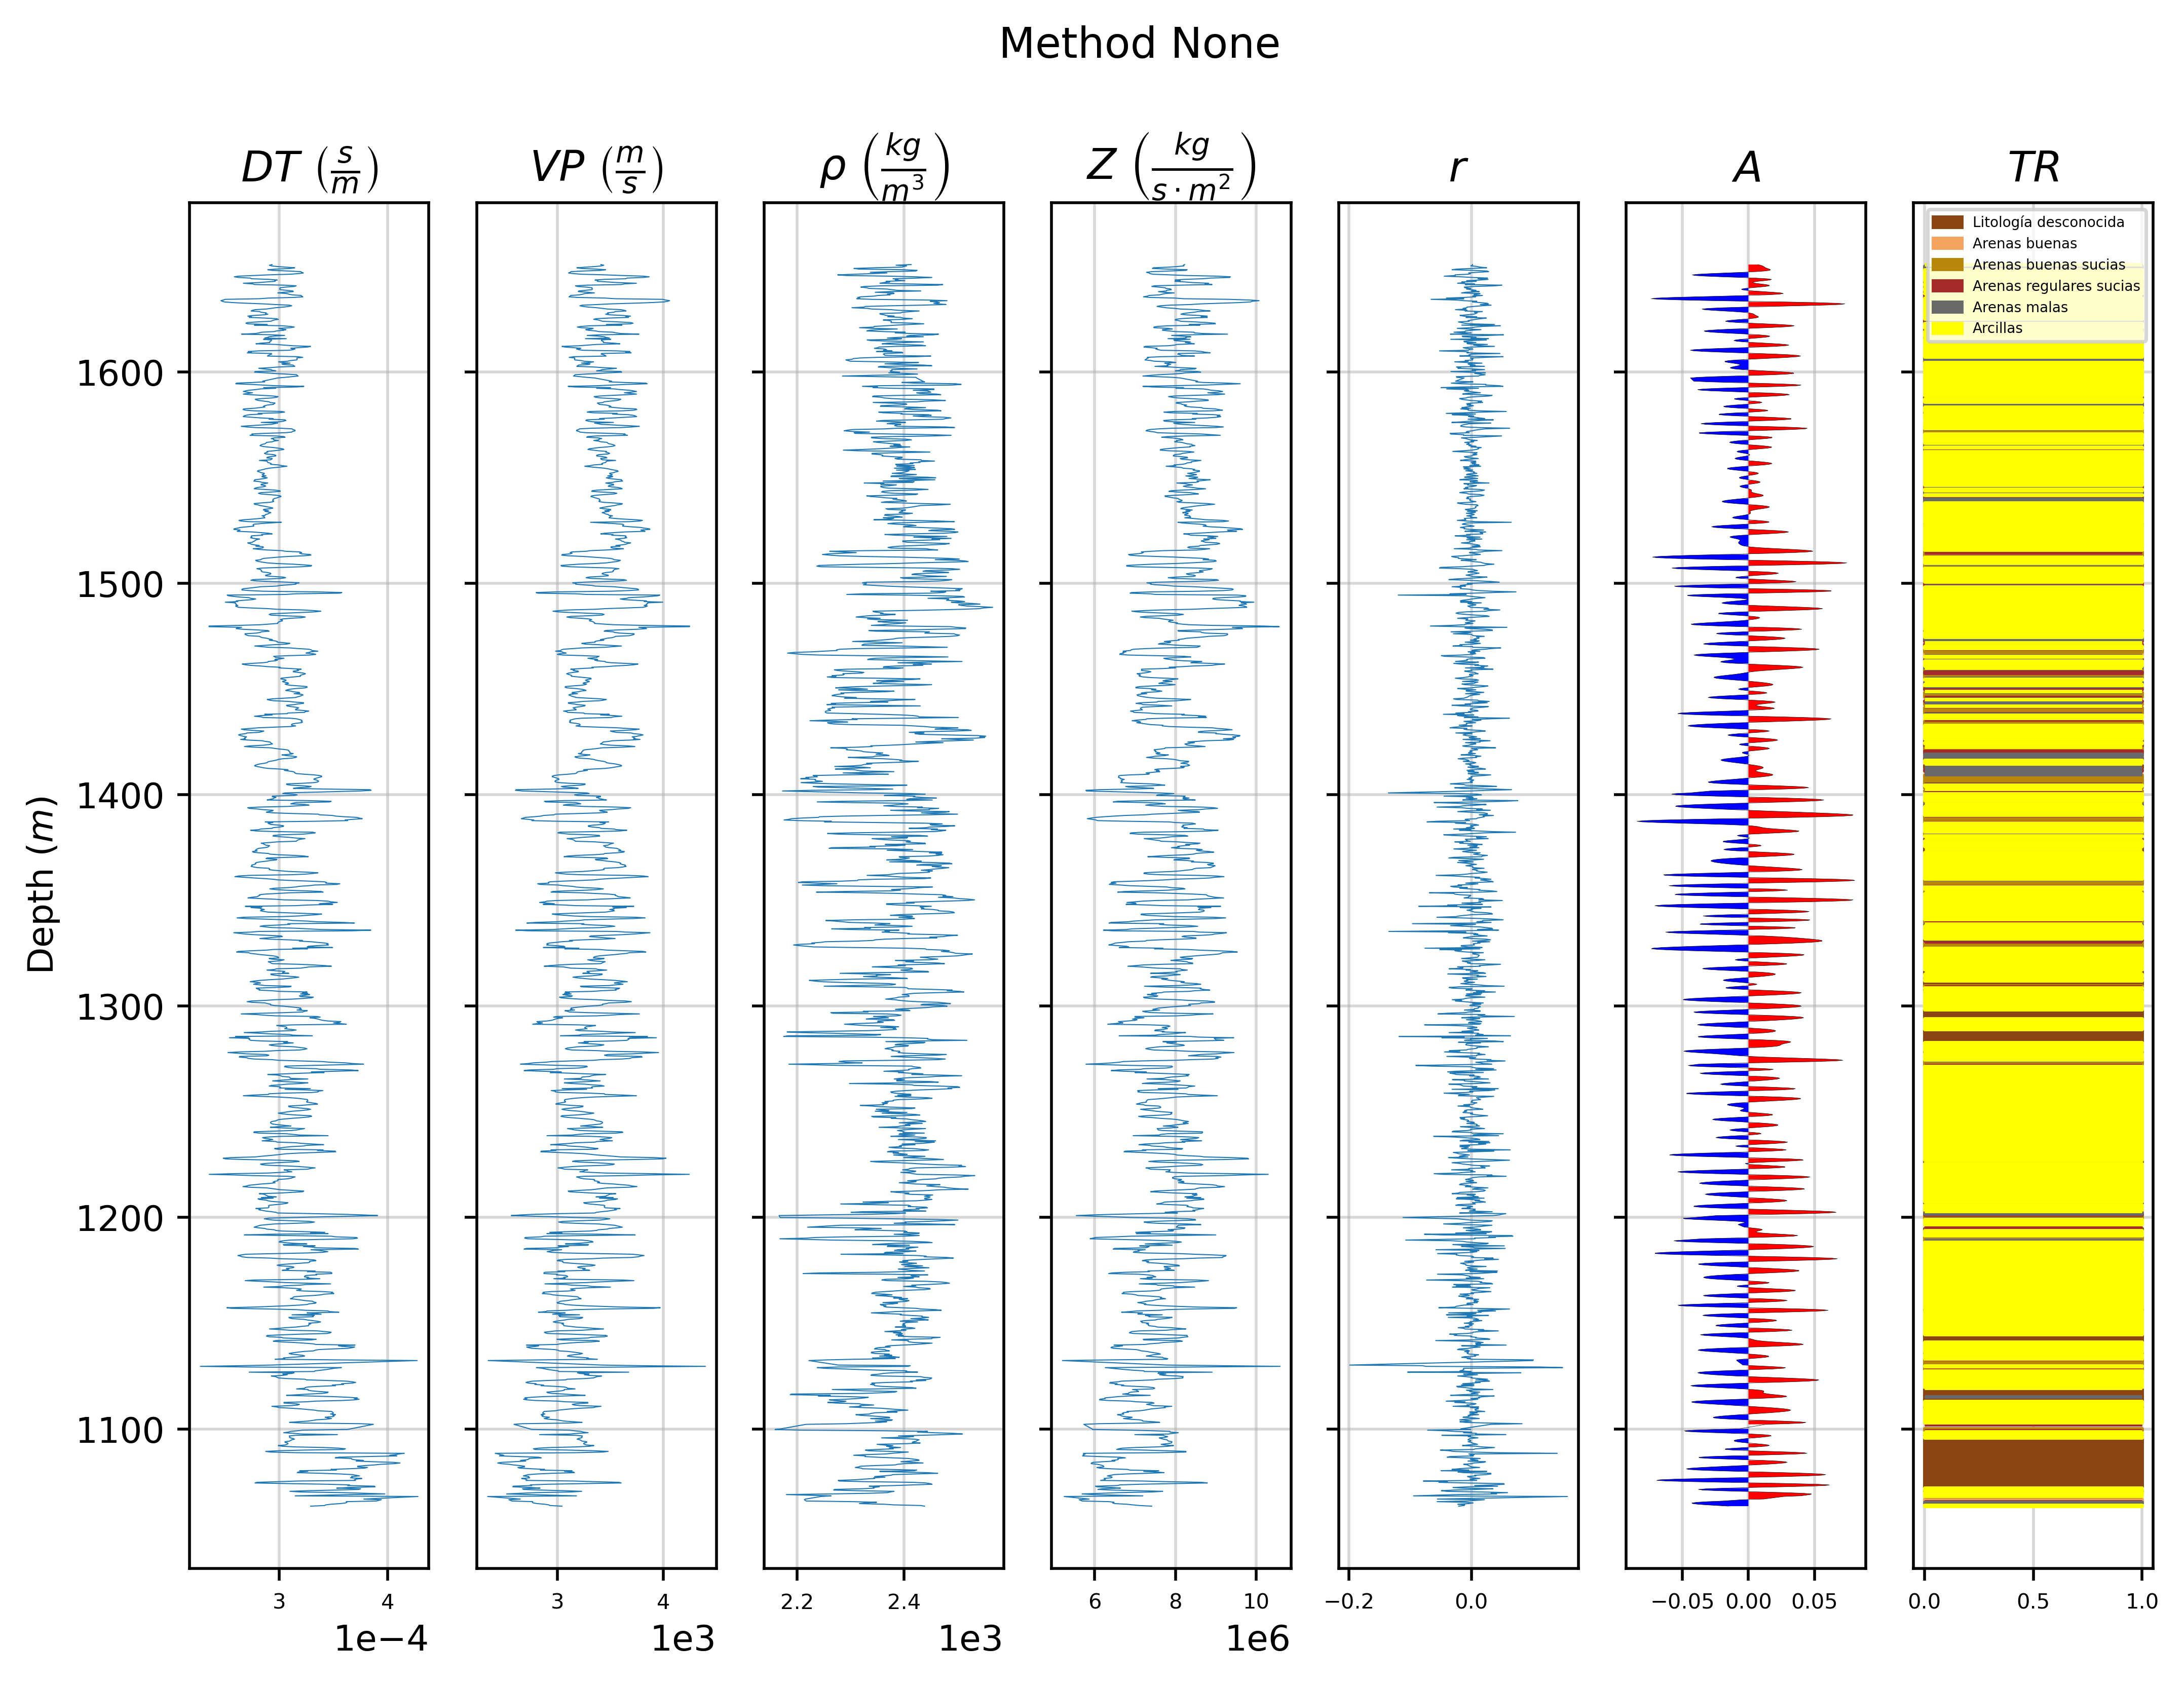

In [23]:
method = None # r any, r < 0.3, r < 0.1, None
r = 'r'
plot_results(df, method, r)

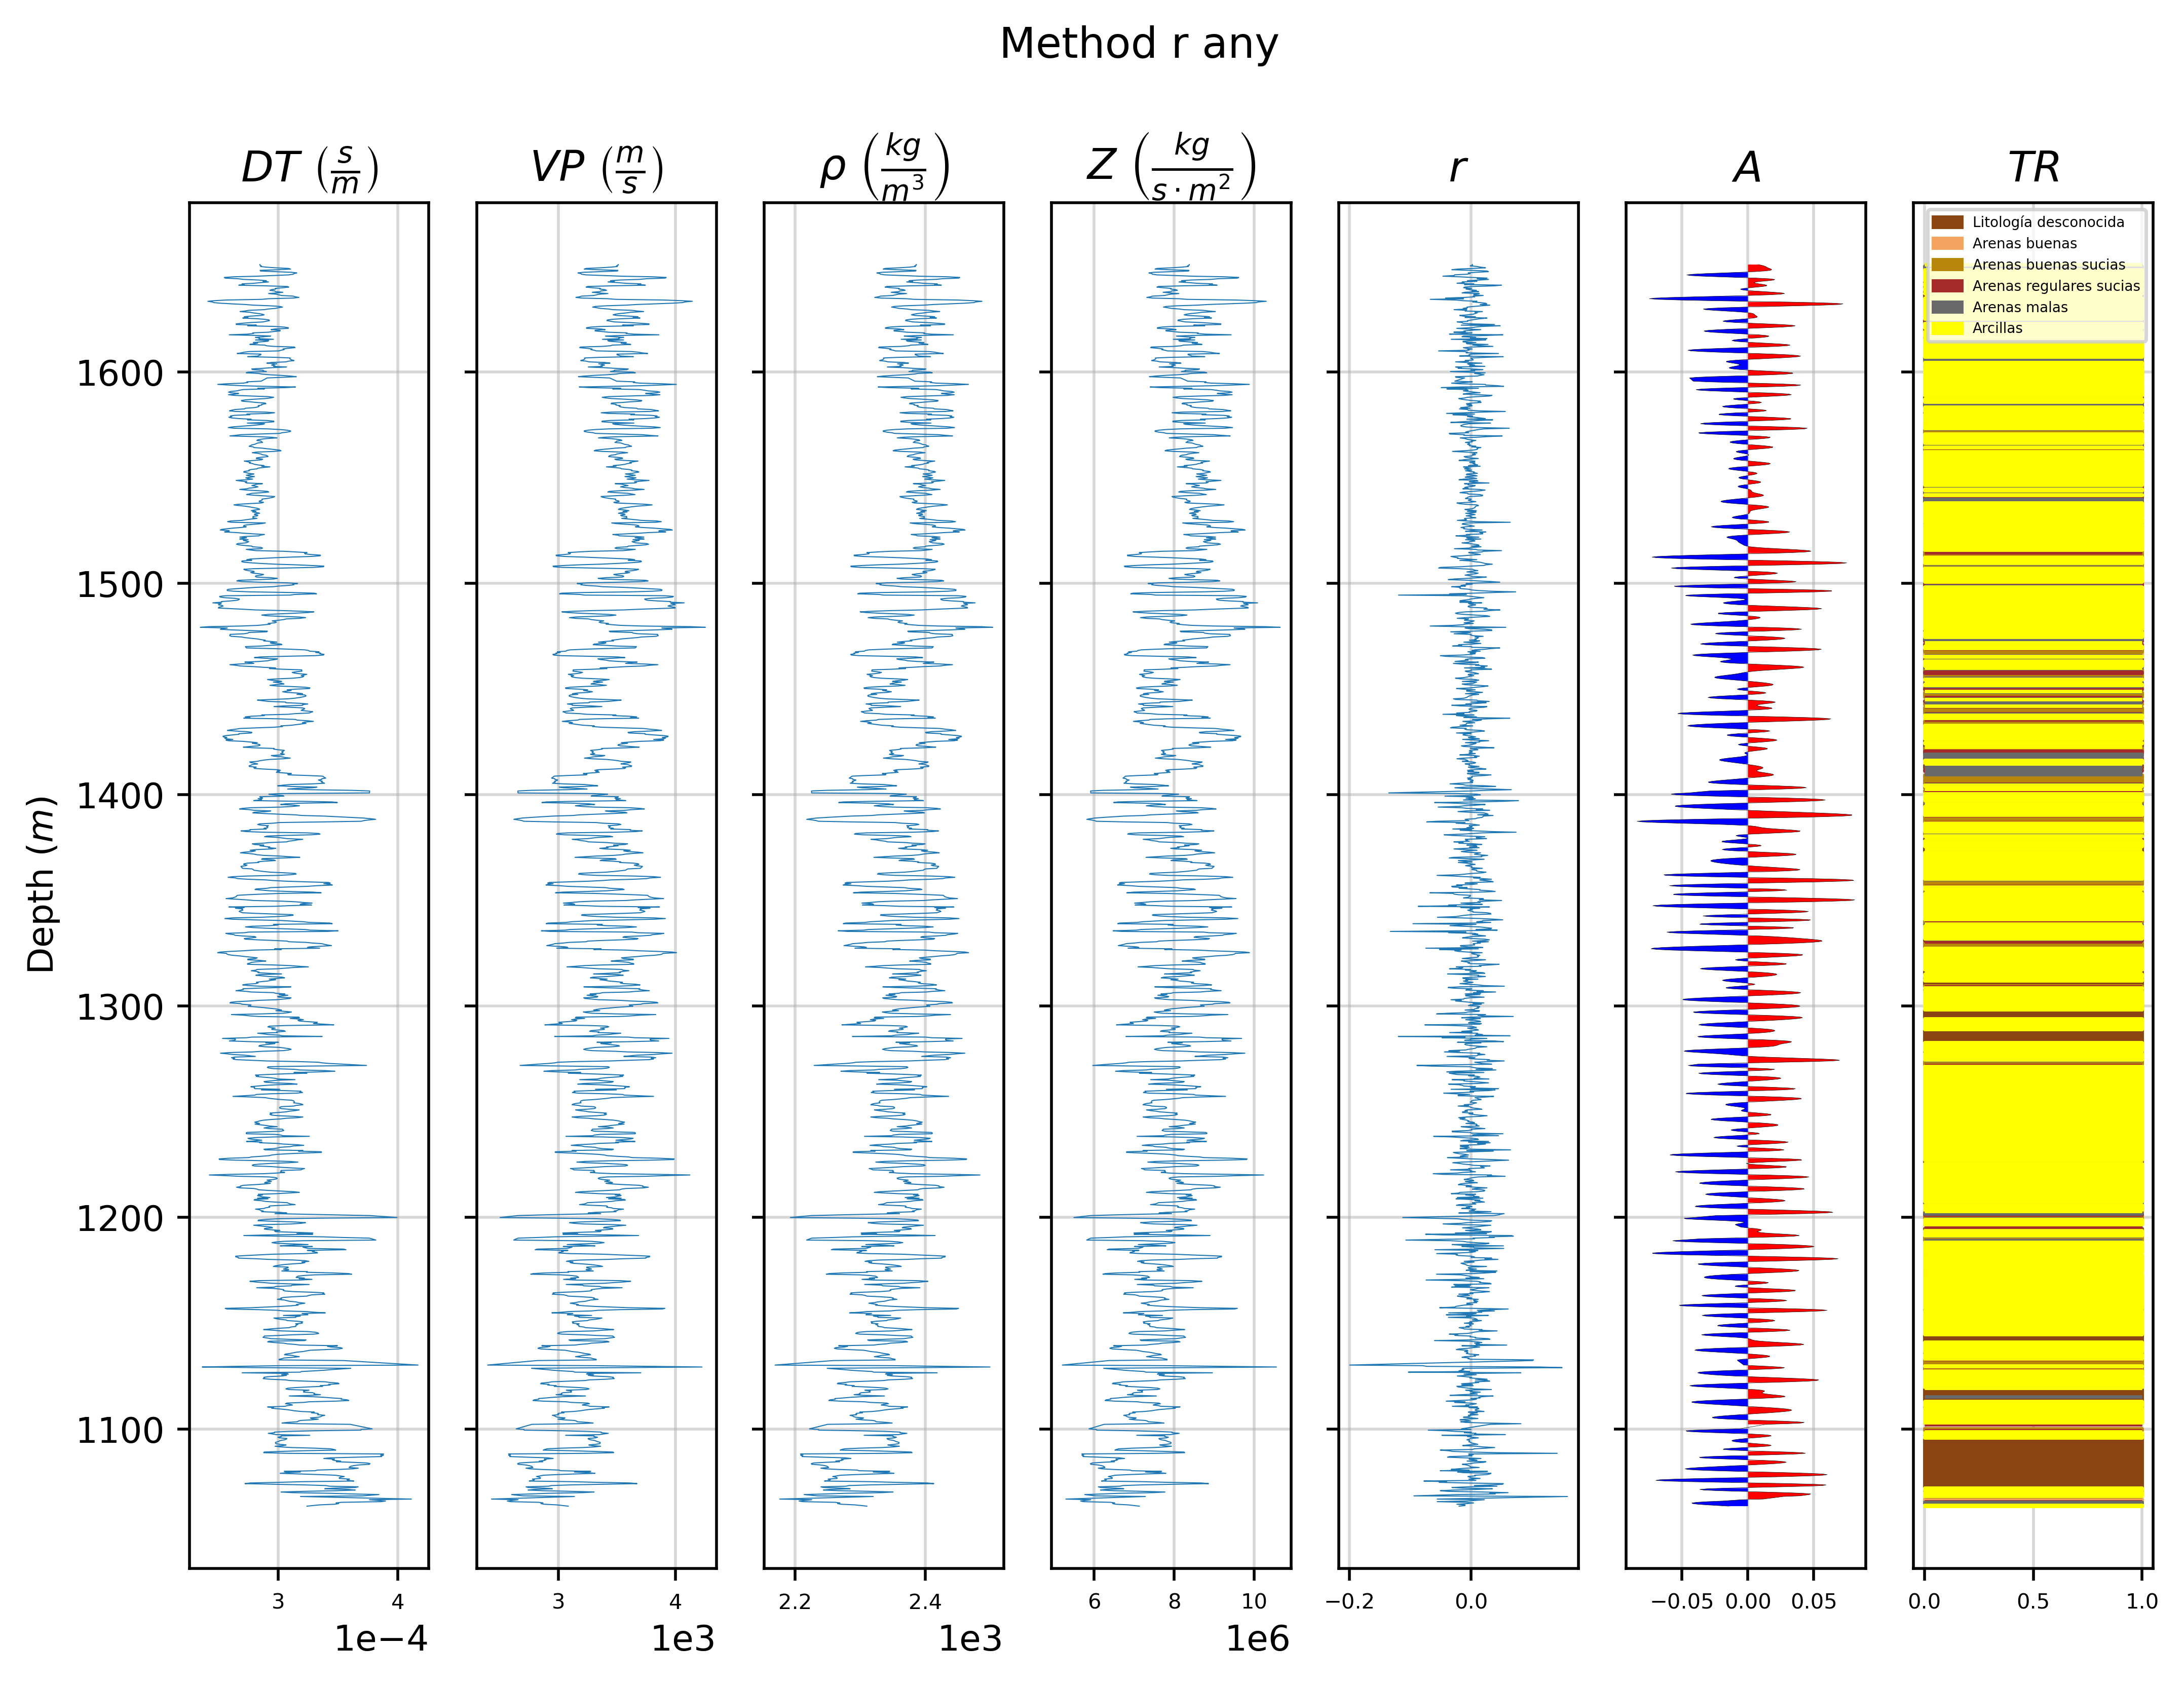

In [24]:
method = 'r any' # r any, r < 0.3, r < 0.1, None
r = 'r_prime'
plot_results(df, method, r)

In [25]:
print('='*50, 'Error for VP', '='*50)
L1_error(df['VP'], df[f'VP_{method}'])
L2_error(df['VP'], df[f'VP_{method}'])
print('='*50, 'Error for RHOB', '='*50)
L1_error(df['RHOB'], df[f'RHOB_{method}'])
L2_error(df['RHOB'], df[f'RHOB_{method}'])
print('='*50, 'Error for Z', '='*50)
L1_error(df['Z'], df[f'Z_{method}'])
L2_error(df['Z'], df[f'Z_{method}'])

================================================== Error for VP ==================================================
L1 error: 4.23%
L2 error: 0.13%
================================================== Error for RHOB ==================================================
L1 error: 1.93%
L2 error: 0.05%
================================================== Error for Z ==================================================
L1 error: 3.86%
L2 error: 0.12%


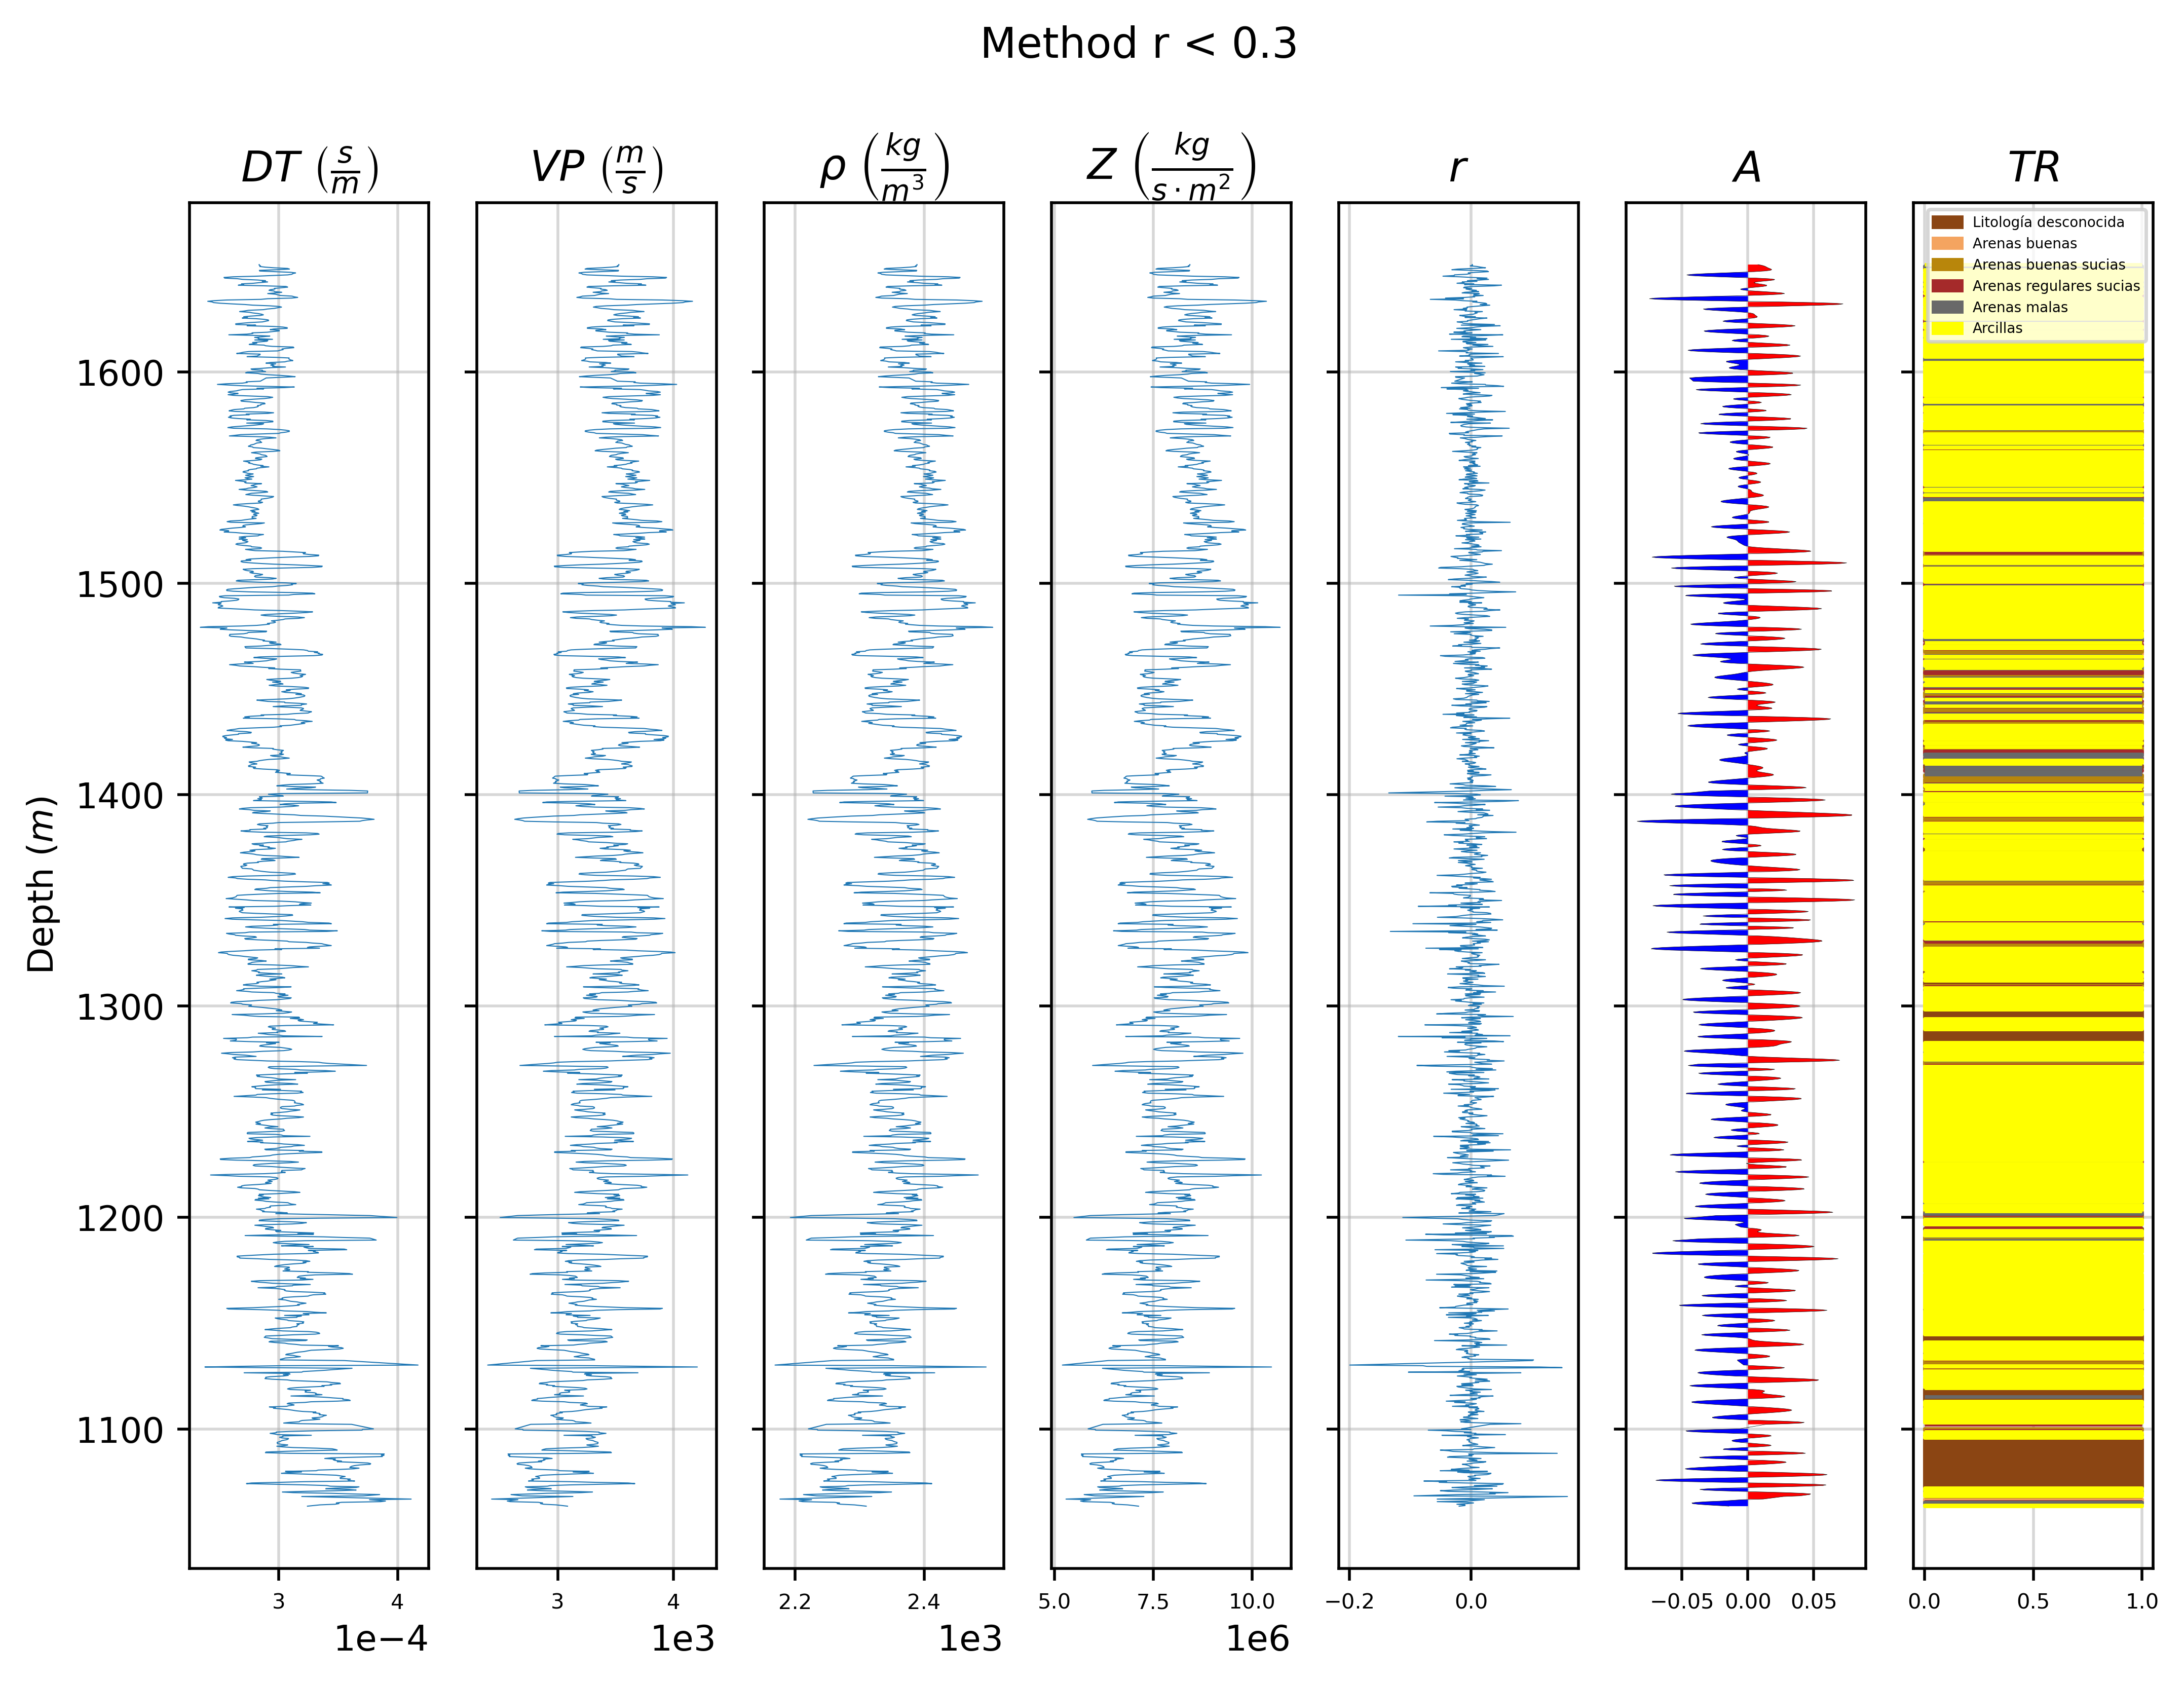

In [26]:
method = 'r < 0.3' # r any, r < 0.3, r < 0.1, None
r = 'r_prime'
plot_results(df, method, r)

In [27]:
print('='*50, 'Error for VP', '='*50)
L1_error(df['VP'], df[f'VP_{method}'])
L2_error(df['VP'], df[f'VP_{method}'])
print('='*50, 'Error for RHOB', '='*50)
L1_error(df['RHOB'], df[f'RHOB_{method}'])
L2_error(df['RHOB'], df[f'RHOB_{method}'])
print('='*50, 'Error for Z', '='*50)
L1_error(df['Z'], df[f'Z_{method}'])
L2_error(df['Z'], df[f'Z_{method}'])

================================================== Error for VP ==================================================
L1 error: 4.34%
L2 error: 0.13%
================================================== Error for RHOB ==================================================
L1 error: 1.94%
L2 error: 0.05%
================================================== Error for Z ==================================================
L1 error: 4.01%
L2 error: 0.13%


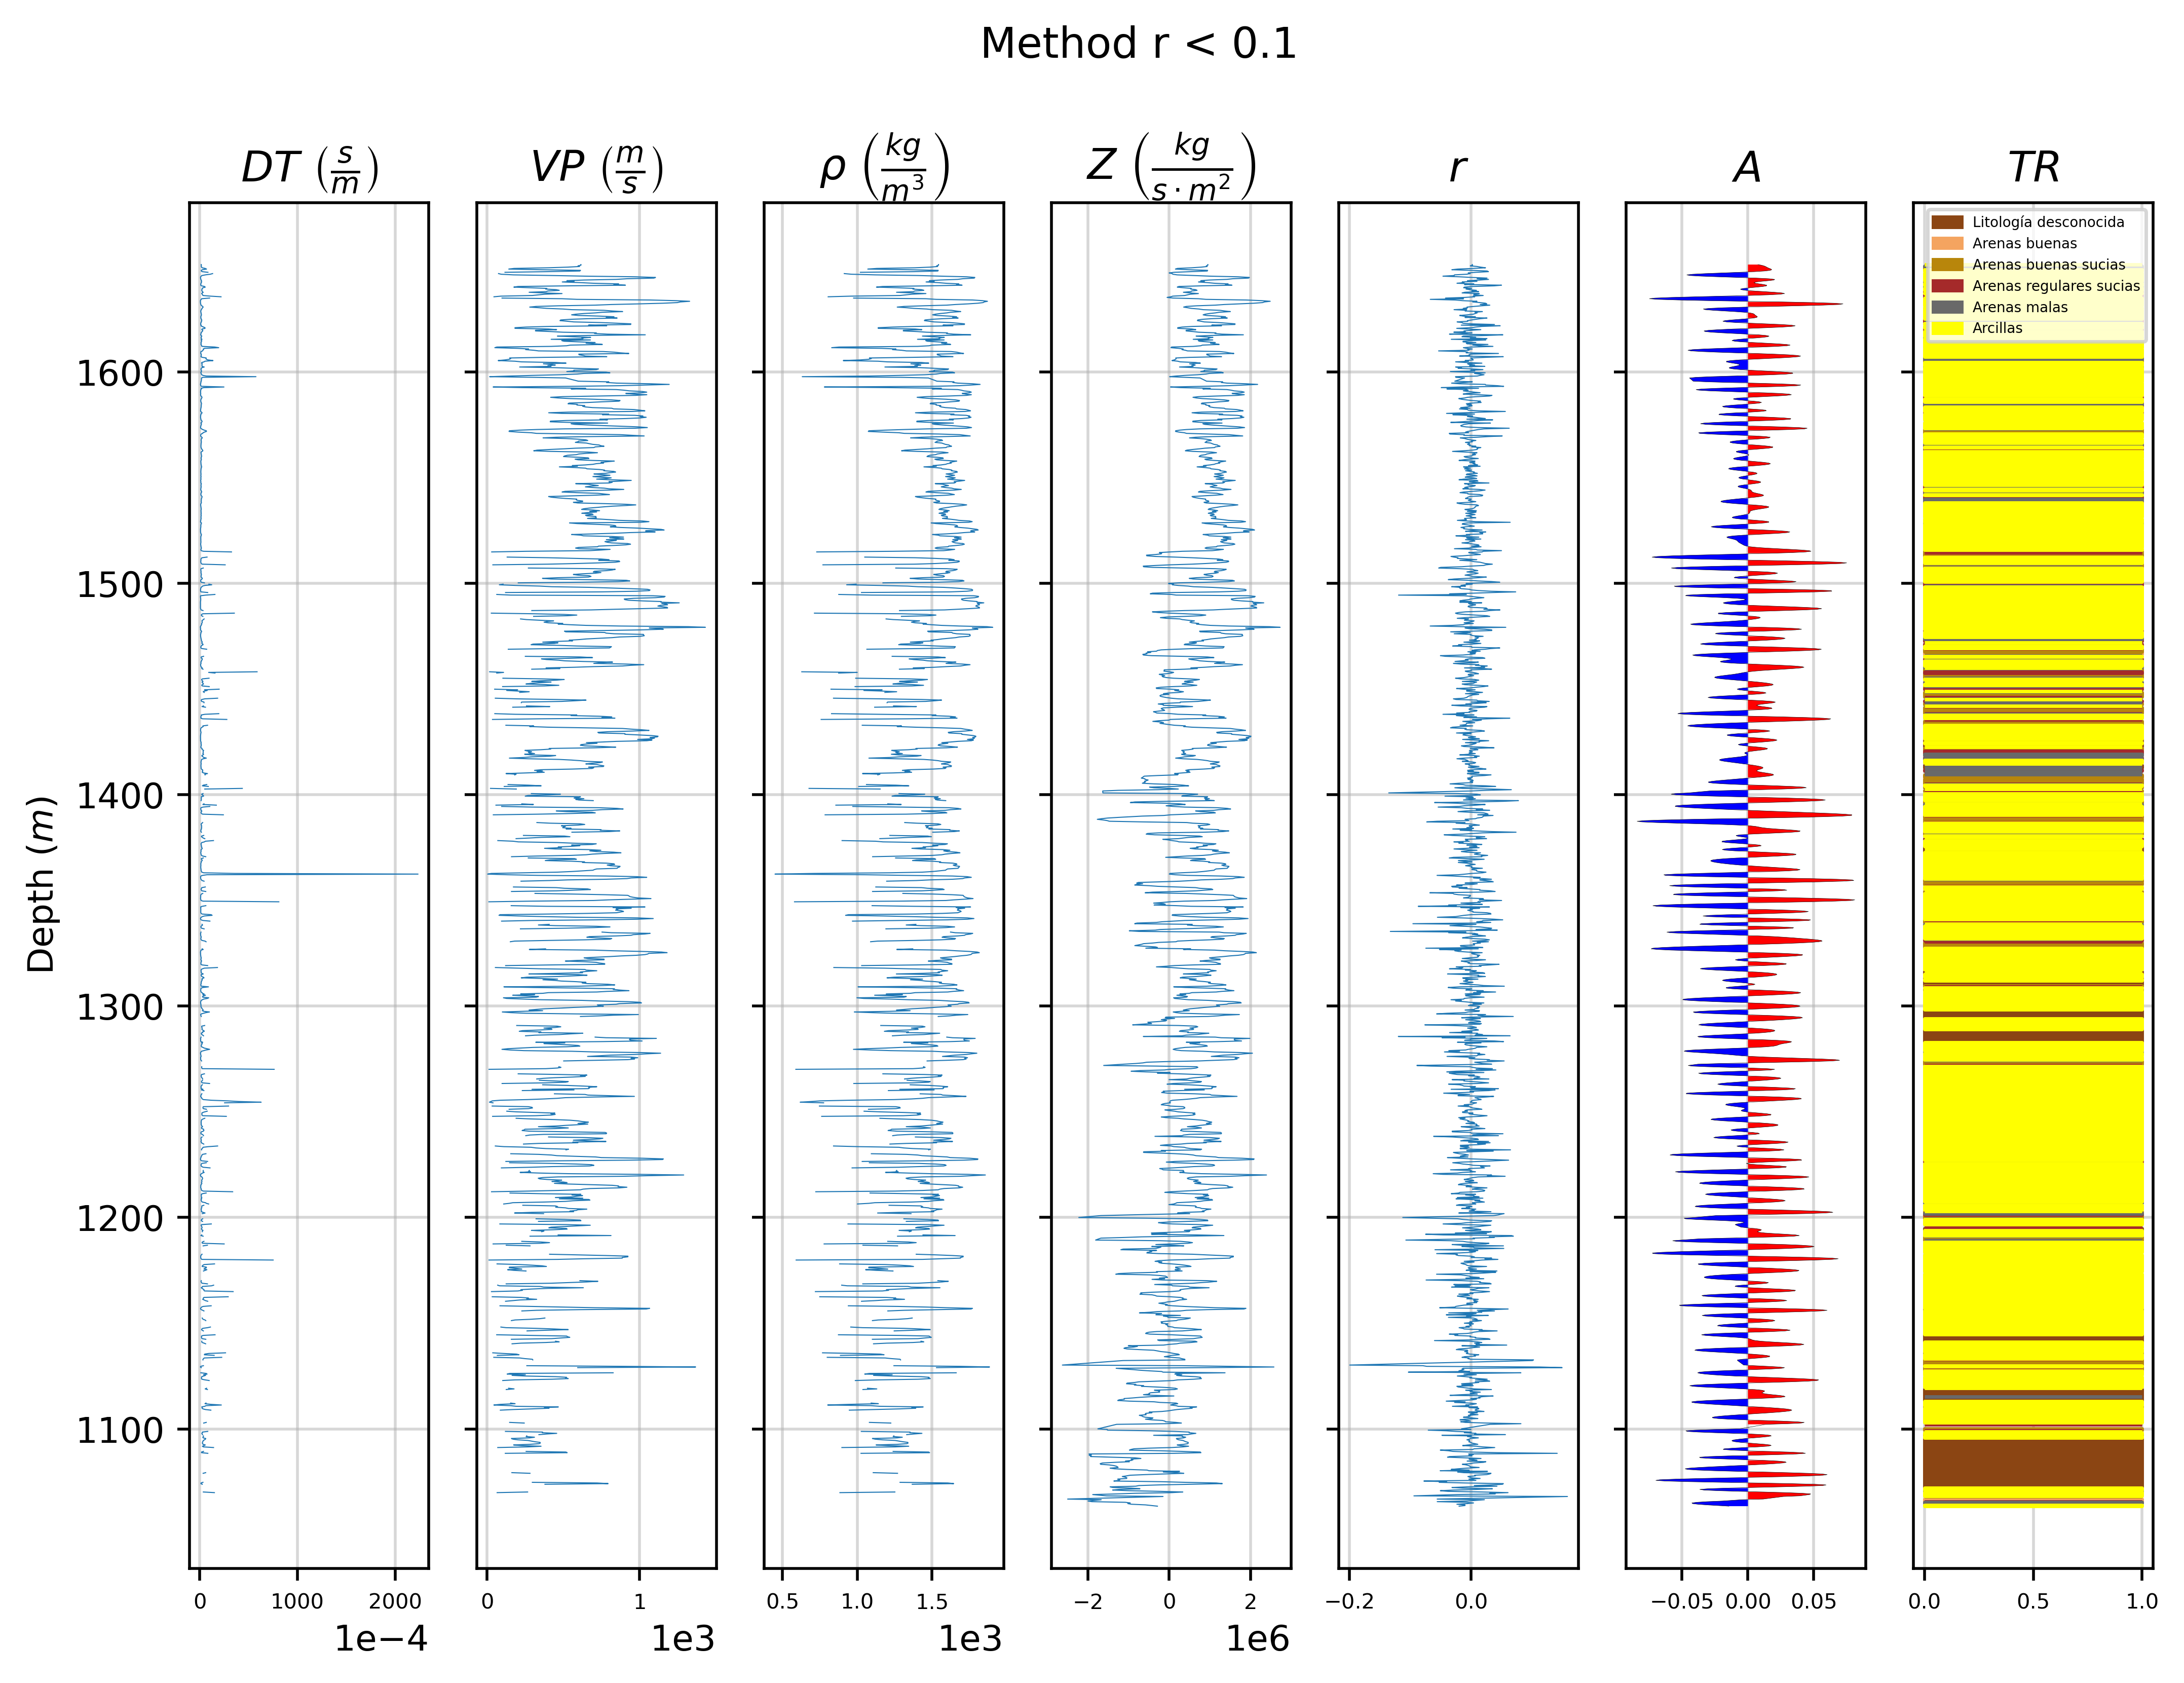

In [28]:
method = 'r < 0.1' # r any, r < 0.3, r < 0.1, None
r = 'r_prime'
plot_results(df, method, r)

In [29]:
print('='*50, 'Error for VP', '='*50)
L1_error(df['VP'], df[f'VP_{method}'])
L2_error(df['VP'], df[f'VP_{method}'])
print('='*50, 'Error for RHOB', '='*50)
L1_error(df['RHOB'], df[f'RHOB_{method}'])
L2_error(df['RHOB'], df[f'RHOB_{method}'])
print('='*50, 'Error for Z', '='*50)
L1_error(df['Z'], df[f'Z_{method}'])
L2_error(df['Z'], df[f'Z_{method}'])

================================================== Error for VP ==================================================
L1 error: 64.23%
L2 error: 1.69%
================================================== Error for RHOB ==================================================
L1 error: 30.18%
L2 error: 0.81%
================================================== Error for Z ==================================================
L1 error: 94.10%
L2 error: 2.17%


In summary, the methods used for sesmic inversion in this code rely on the recursive approach and were the following:
    
1) Method 1

$Z_i = Z_0\prod \frac{1+r_i}{1-r_i}$

2) Method 2, $|r|<0.3$

$Z(t_m)=Z(t_0)e^{2\sum_{t=t_0}^{t_m}r(t)\Delta t}$

3) Method 3, $|r|<0.1$

$Z(t_m)=2Z_0\sum_{t=t_0}^{t_m}r(t_m)\Delta t$


We observed that only in the first two approaches (method 1 and method 2), $\rho$ and $v$ were correctly calculated with an small error (error<5% for L1 norm and error<1% for L2 norm). On the other hand, the reflectivity profile, with values of $r$ greater than 0.2 (roughly at a depth of 1100m), did not allow method 3 to converge as expected, resulting in missing calculated values.

Method 1 does not require $r$ to be below a specific threshold value, while method 2 requires |r| < 0.3, a condition that is met. As a result, the first two methods yield a good recursive inversion result, whereas the third one does not meet the conditions for a successful outcome

#### Calculate Garden relation for each TR

$\rho = aV_p^b$

a: 2159.809502043112         b: 0.011245270704840358


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


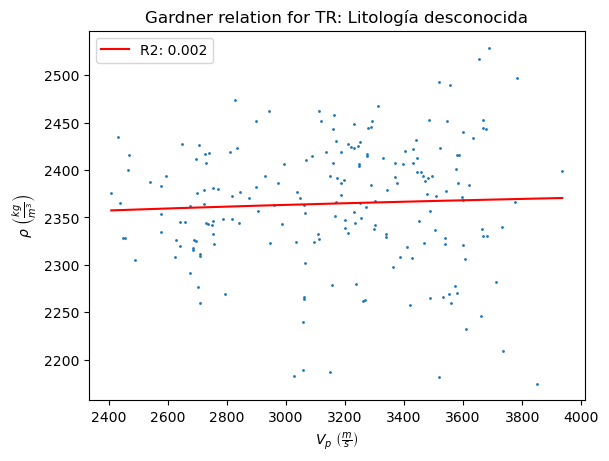

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


a: 1307.8443185441681         b: 0.06612494527858385


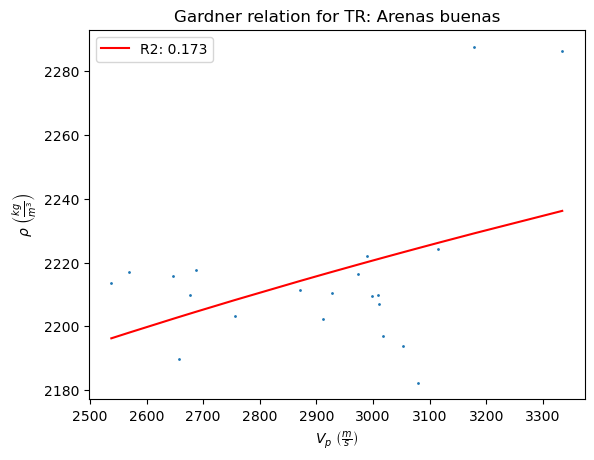

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


a: 809.2326812800108         b: 0.128359094507471


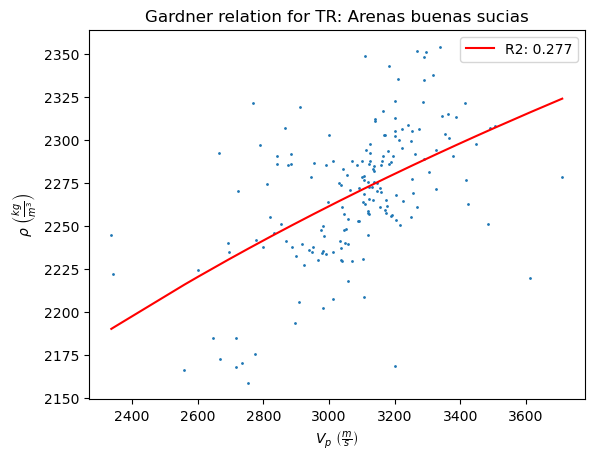

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


a: 1046.5713529977268         b: 0.09952380665914037


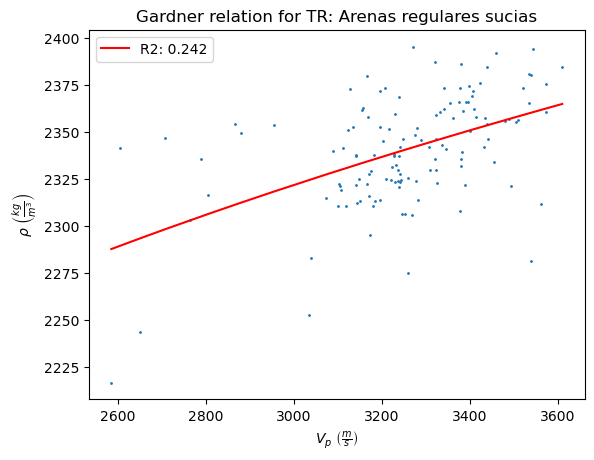

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


a: 1511.4370892339048         b: 0.0553515196077176


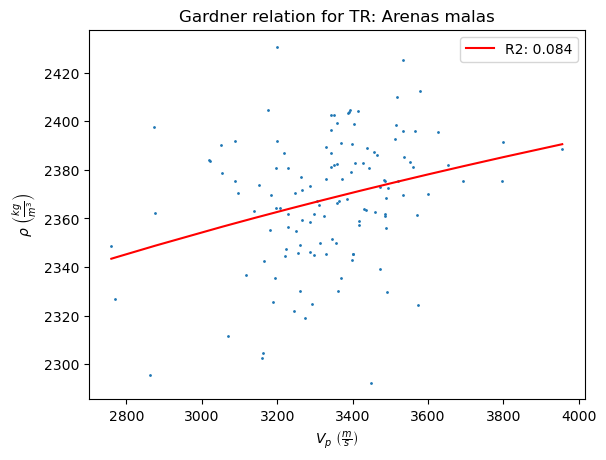

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


a: 1026.6617061352886         b: 0.1053216062401073


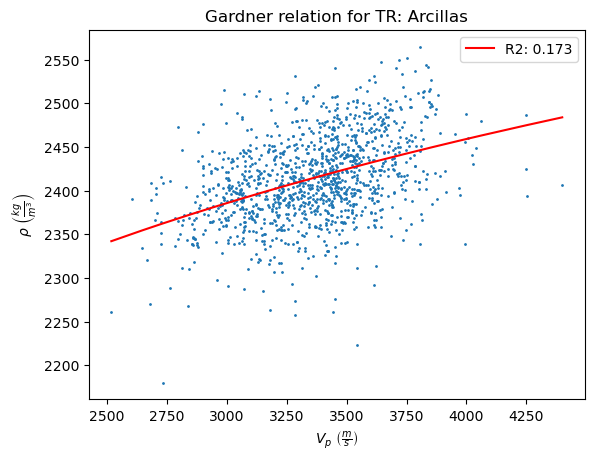

In [30]:
calc_Gardner_relation(df)

#### No Garden relation

$\rho = aZ+b$

a: 2.0859470347816973e-05         b: 2208.5359873570656


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


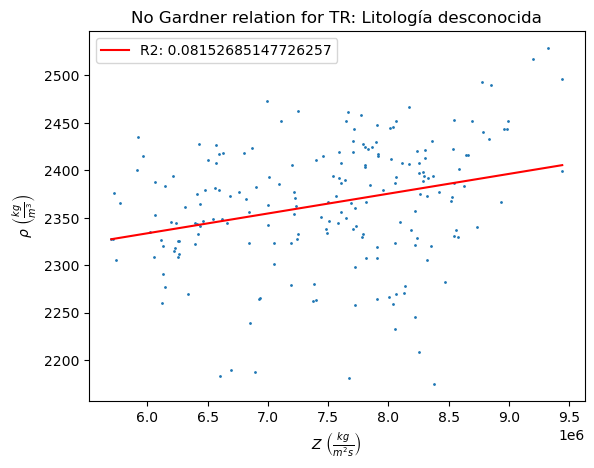

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


a: 2.844761171164373e-05         b: 2032.4242740391985


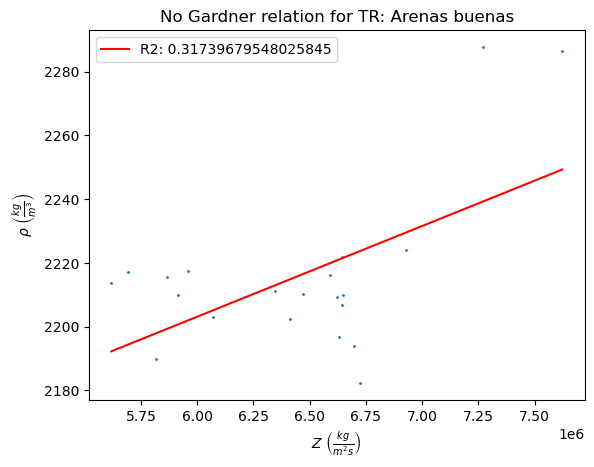

a: 4.753745210526847e-05         b: 1936.1128391879993


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


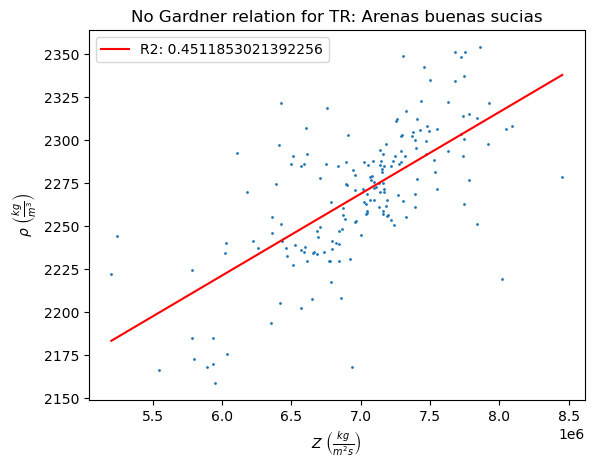

C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


a: 3.6218951673062794e-05         b: 2064.345443187208


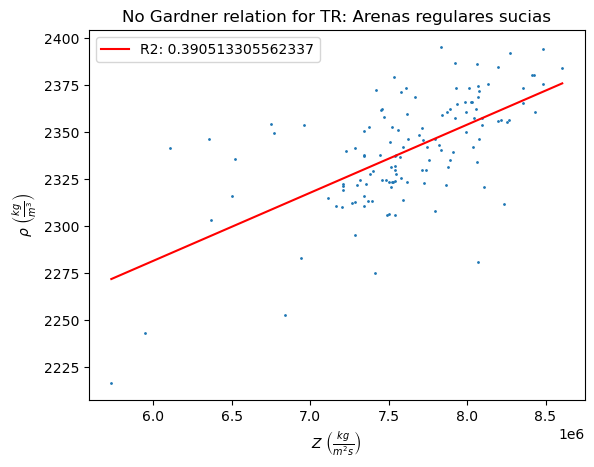

a: 2.4284748672663415e-05         b: 2176.014295873776


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


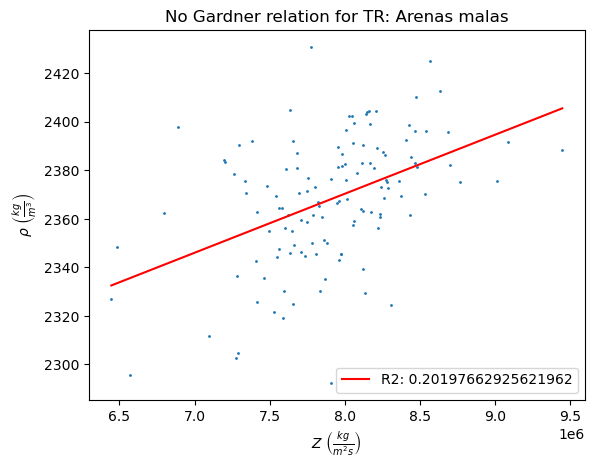

a: 4.004791810627591e-05         b: 2088.9317350895376


C:\Users\serfe\AppData\Roaming\Python\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


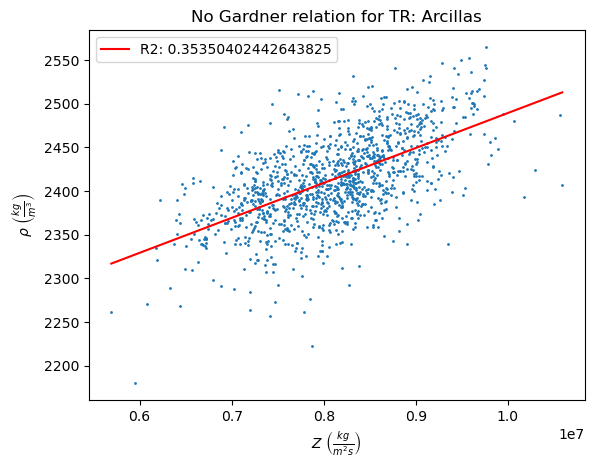

In [31]:
calc_NoGardner_relation(df)

In general, we obtain a better correlation between $\rho$ and $Z$ than between $\rho$ and $V_p$, suggesting in this case it would be better and more accurate to calculate $\rho$ using Z values instead of using $V_p$ values.